In [7]:
import numpy as np
import sys
import cv2
import torch
import copy
import imageio
import random
import scipy
from tqdm import tqdm
from fastseg import MobileV3Small
from IPython.display import Video
from IPython.display import HTML
from base64 import b64encode
%matplotlib inline
# %matplotlib ipympl
import matplotlib.pyplot as plt
from pathlib import Path
np.set_printoptions(suppress=True)

In [8]:
class simple_lane_detector():
  def __init__(self, model_path=None):
    if torch.cuda.is_available():
      self.device = "cuda"
      self.model = torch.load(model_path).to(self.device)
    else:
      self.model = torch.load(model_path, map_location=torch.device("cpu"))
      self.device = "cpu"
    self.model.eval()

  def _predict(self, tensor):
    # Expected input is tensor of image in the right format
    with torch.no_grad():
      model_output = self.model(tensor)
      # Change to np array and squeeze to get 
      model_output = model_output.detach().squeeze().cpu().numpy()
      model_output = np.transpose(model_output,(1,2,0))
    return model_output
      
  def predict_raw_image(self, img):
    # img is assumed to be in RGB format
    # prepare image by flipping dimension and turn into torch tensor
    # input image is assumed to be HWC, changing to CHW
    img = np.transpose(img, (2,0,1))
    # change to tensor and send to device. Unsqueeze to match BCHW format (B is for batch)
    x_tensor = torch.from_numpy(img).float().to(self.device).unsqueeze(0)
    return self._predict(x_tensor)

  def predict_img_file(self, filename):
    # Read image from filename/path
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return self.predict_raw_image(img)

  def detect(self, img_raw=None, img_file=None):
    if img_raw is not None:
      model_output = self.predict_raw_image(img_raw)
      background, left, right = model_output[:,:,0], model_output[:,:,1], model_output[:,:,2] 
      return background, left, right
    elif img_file:
      model_output = self.predict_img_file(img_file)
      background, left, right = model_output[:,:,0], model_output[:,:,1], model_output[:,:,2]
      return background, left, right

  def one_hot_encode(self, label_raw, label_values):
    """
  Convert a segmentation image label array to one-hot format
  by replacing each pixel value with a vector of length num_classes
  # Arguments
      label: The 2D array segmentation image label
      label_values
      
  # Returns
      A 2D array with the same width and hieght as the input, but
      with a depth size of num_classes
  """
    semantic_map = []
    for colour in label_values:
      equality = np.equal(label_raw, colour)
      class_map = np.all(equality, axis = -1)
      semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)
    return semantic_map

  def read_label_file(self, label_file):
    # Read label from filename/path
    label = cv2.imread(label_file)
    return label

  def visualize(self, img_raw=None, img_file=None, label_raw=None, label_file=None):
    # Function for visualising predictions side by side with ground truth and image
    columns = 3
    rows = 1
    fig = plt.figure(figsize=(16, 9))
    if img_raw is not None:
      prediction = self.predict_raw_image(img_raw)
      fig.add_subplot(rows, columns, 1)
      plt.imshow(img_raw)
      if label_raw:
        # make one hot encoded label
        label_raw = self.one_hot_encode(label_raw, (0,1,2)).astype(float)
        fig.add_subplot(rows, columns, 2)
        plt.imshow(label_raw)
      elif label_file:
        label = self.read_label_file(label_file)
        label = self.one_hot_encode(label, (0,1,2)).astype(float)
        fig.add_subplot(rows, columns, 2)
        plt.imshow(label)
      fig.add_subplot(rows, columns, 3)
      plt.imshow(prediction)
    elif img_file:
      prediction = self.predict_img_file(img_file)
      fig.add_subplot(rows, columns, 1)
      img = cv2.imread(img_file)
      plt.imshow(img)
      if label_raw:
        # make one hot encoded label
        label_raw = self.one_hot_encode(label_raw, (0,1,2)).astype(float)
        fig.add_subplot(rows, columns, 2)
        plt.imshow(label_raw)
      elif label_file:
        label = self.read_label_file(label_file)
        label = self.one_hot_encode(label, (0,1,2)).astype(float)
        fig.add_subplot(rows, columns, 2)
        plt.imshow(label)
      fig.add_subplot(rows, columns, 3)
      plt.imshow(prediction)
    plt.show()


  # Perform reverse one-hot-encoding on labels / preds
  def reverse_one_hot(self, image):
      """
      Transform a 2D array in one-hot format (depth is num_classes),
      to a 2D array with only 1 channel, where each pixel value is
      the classified class key.
      # Arguments
          image: The one-hot format image 
          
      # Returns
          A 2D array with the same width and hieght as the input, but
          with a depth size of 1, where each pixel value is the classified 
          class key.
      """
      x = np.argmax(image, axis = -1)
      return x

  # Perform colour coding on the reverse-one-hot outputs
  def colour_code_segmentation(self, image, label_values):
      """
      Given a 1-channel array of class keys, colour code the segmentation results.
      # Arguments
          image: single channel array where each value represents the class key.
          label_values

      # Returns
          Colour coded image for segmentation visualization
      """
      colour_codes = np.array(label_values)
      x = colour_codes[image.astype(int)]
      return x



In [9]:
T = np.eye(4)
T[2,3] = 1300
print(np.dot(T, np.array([0,0,0,1])[:, None])[:3])


[[   0.]
 [   0.]
 [1300.]]


In [10]:
class IPM(object):
    """
    Inverse perspective mapping to a bird-eye view. Assume pin-hole camera model.
    There are detailed explanation of every step in the comments, and variable names in the code follow these conventions:
    `_c` for camera coordinates
    `_w` for world coordinates
    `uv` for perspective transformed uv 2d coordinates (the input image)
    """
    def __init__(self, camera_info, ipm_info):
        self.camera_info = camera_info
        self.ipm_info = ipm_info

        ## Construct matrices T, R, K
        self.T = np.eye(4)
        self.T[2, 3] = -camera_info.camera_height # 4x4 translation matrix in 3d space (3d homo coordinate)
        _cy = np.cos(camera_info.yaw   * np.pi / 180.)
        _sy = np.sin(camera_info.yaw   * np.pi / 180.)
        _cp = np.cos(camera_info.pitch * np.pi / 180.)
        _sp = np.sin(camera_info.pitch * np.pi / 180.)
        tyaw = np.array([[_cy, 0, -_sy],
                         [0, 1, 0],
                         [_sy, 0, _cy]])
        tyaw_inv = np.array([[_cy, 0, _sy],
                             [0, 1, 0],
                             [-_sy, 0, _cy]])
        tpitch = np.array([[1, 0, 0],
                           [0, _cp, -_sp],
                           [0, _sp, _cp]])
        tpitch_inv = np.array([[1, 0, 0],
                               [0, _cp, _sp],
                               [0, -_sp, _cp]])
        self.R = np.dot(tyaw, tpitch) # 3x3 Rotation matrix in 3d space
        self.R_inv = np.dot(tpitch_inv, tyaw_inv)
        self.K = np.array([[camera_info.f_x, 0, camera_info.u_x],
                           [0, camera_info.f_y, camera_info.u_y],
                           [0, 0, 1]]).astype(float) # 3x3 intrinsic perspective projection matrix

        ## The ground plane z=0 in the world coordinates, transform to a plane `np.dot(self.normal_c, point) = self.const_c` in the camera coordinates. 
        # This is used to find (x,y,z)_c according to (u,v). See method `uv2xy` for detail.
        self.normal_c = np.dot(self.R, np.array([0,0,1])[:, None]) # normal of ground plane equation in camera coordinates
        self.const_c = np.dot(self.normal_c.T, 
                              np.dot(self.R,
                                     np.dot(self.T, np.array([0,0,0,1])[:, None])[:3])) # constant of ground plane equation in camera coordinates

        ## Get the limit to be converted on the uv map (must below vanishing point)
        # To calculate (u,v) of the vanishing point on the uv map of delta vector v=[0,1,0] in the world coordinates
        # homo coordinates of a vector will be v_4 = [0, 1, 0, 0], mapping this vector to camera coordinate:
        # vc_3 = np.dot(R_4, np.dot(T_4, v_4))[:3] = np.dot(R, v), the 2d homo coordinate of the vanishing point will be at 
        # lim_{\lambda -> \infty} np.dot(K, lambda * vc_3) = np.dot(K, vc_3)

        # lane_vec_c = np.dot(self.R, np.array([0,1,0])[:, None]) # lane vector in camera coordinates
        # lane_vec_homo_uv = np.dot(self.K, lane_vec) # lane vector on uv map (2d homo coordinate)
        lane_vec_homo_uv = np.dot(self.K, np.dot(self.R, np.array([0,1,0])[:, None])) # lane vector on uv map (2d homo coordinate)
        print(lane_vec_homo_uv)
        vp = self.vp = lane_vec_homo_uv[:2] / lane_vec_homo_uv[2] # coordinates of the vanishing point of lanes on uv map

        # UGLY: This is an ugly op to ensure the converted area do not goes beyond the vanishing point, as the camera intrinsic/extrinsic parameters are not accurate in 
        # my case.
        ipm_top = self.ipm_top = max(ipm_info.top, vp[1]+ipm_info.input_height/15) 
        uv_limits = self.uv_limits = np.array([[ipm_info.left, ipm_top],
                              [ipm_info.right, ipm_top],
                              [vp[0][0], ipm_top],
                              [vp[0][0], ipm_info.bottom]]).T # the limits of the area on the uv map to be IPM-converted

        ## The x,y limit in the world coordinates is used to calculate xy_grid, and then the corresponding uv_grid
        self.xy_limits = self.uv2xy(uv_limits)
        xmin, xmax = min(self.xy_limits[0]), max(self.xy_limits[0])
        ymin, ymax = min(self.xy_limits[1]), max(self.xy_limits[1])
        stepx = (xmax - xmin) / ipm_info.out_width  # x to output pixel ratio
        stepy = (ymax - ymin) / ipm_info.out_height # y to output pixel ratio

        # xy_grid: what x,y coordinates in world coordinates will be stored in every output image pixel
        self.xy_grid = np.array([[(xmin + stepx * (0.5 + j), ymax - stepy * (0.5 + i)) for j in range(ipm_info.out_width)]
                                 for i in range(ipm_info.out_height)]).reshape(-1, 2).T
        # uv_grid: what u,v coordiantes on the uv map will be stored in every output image pixel
        self.uv_grid = self.xy2uv(self.xy_grid).astype(int)
        self.uv_grid = self.uv_grid * ((self.uv_grid[0] > ipm_info.left) * (self.uv_grid[0] < ipm_info.right) *\
                                       (self.uv_grid[1] > ipm_top) * (self.uv_grid[1] < ipm_info.bottom))
        self.uv_grid = tuple(self.uv_grid.reshape(2, ipm_info.out_height, ipm_info.out_width))
        self.uv_grid = (self.uv_grid[1], self.uv_grid[0])

    def xy2uv(self, xys): # all points have z=0 (ground plane): w (u,v,1) = KRT (x,y,z)_w
        xyzs = np.vstack((xys, -self.camera_info.camera_height * np.ones(xys.shape[1]))) # (x,y,z) after translation
        xyzs_c = np.dot(self.K, np.dot(self.R, xyzs)) # w(u,v,1) (2d homo)
        return xyzs_c[:2] / xyzs_c[2]

    def uv2xy(self, uvs): # all points have z=0 (ground plane): find (x,y,z)_c first, then x_w, y_w = (R^-1 (x,y,z)_c)[:2]
        uvs = (uvs - np.array([self.camera_info.u_x, self.camera_info.u_y])[:, None]) /\
              np.array([self.camera_info.f_x, self.camera_info.f_y])[:, None] # converted using camara intrinsic parameters
        uvs = np.vstack((uvs, np.ones(uvs.shape[1])))
        xyz_c = (self.const_c / np.dot(self.normal_c.T, uvs)) * uvs # solve the equation, get (x,y,z) on the ground plane in camera coordinates
        xy_w = np.dot(self.R_inv, xyz_c)[:2, :] # (x, y) on the ground plane in the world coordinates
        return xy_w

    def __call__(self, img):
        return self.ipm(img)

    def ipm(self, img):
        out_img = img[self.uv_grid].copy()
        out_img = np.rot90(out_img, 2) #rotate the image 180 degrees
        return out_img

    def reverse_ipm(self, img, shape=None):
        if shape is None:
            shape = img.shape
        out_img = np.zeros(shape)
        out_img[self.uv_grid] = img
        return out_img

class _DictObjHolder(object):
    def __init__(self, dct):
        self.dct = dct

    def __getattr__(self, name):
        return self.dct[name]


In [11]:
def get_intrinsic_matrix(field_of_view_deg, image_width, image_height):
  # For our Carla camera alpha_u = alpha_v = alpha
  # alpha can be computed given the cameras field of view via
  field_of_view_rad = field_of_view_deg * np.pi/180
  alpha = (image_width / 2.0) / np.tan(field_of_view_rad / 2.)
  Cu = image_width / 2.0
  Cv = image_height / 2.0
  return np.array([[alpha, 0, Cu],
                    [0, alpha, Cv],
                    [0, 0, 1.0]])
    
def get_intersection(line1, line2):
  m1, c1 = line1
  m2, c2 = line2
  if m1 == m2:
      return None
  u_i = (c2 - c1) / (m1 - m2)
  v_i = m1*u_i + c1
  return u_i, v_i

def get_two_points_on_line(line):
  m, c = line
  u1 = 1
  u2 = 2
  v1 = m*u1 + c
  v2 = m*u2 + c
  return u1, v1, u2, v2

def get_direction_3d(line, K):
  # Function for getting the direction of the line in the cameraframe
  u1, v1, u2, v2 = get_two_points_on_line(line)
  # create homogenoues coordinates
  p1 = np.array([u1, v1, 1])
  p2 = np.array([u2, v2, 1])
  # find point/vector for points in camera frame
  # this vector will describe the direction of the
  # line which the point belongs to
  K_inv = np.linalg.inv(K)
  cp1 = K_inv @ p1
  cp2 = K_inv @ p2
  # calculate direction vector in cameraframe
  temp = cp2 - cp1
  direction = temp / np.linalg.norm(temp)
  return direction

def angle_between_vectors(a, b):
  cos_alpha = np.dot(a,b)/(np.linalg.norm(a)*np.linalg.norm(b))
  alpha = np.arccos(cos_alpha)
  return alpha


def get_vector_in_camera_frame(u_i, v_i, K):
  # create homogenoues coordinate
  p_infinity = np.array([u_i, v_i, 1])
  K_inv = np.linalg.inv(K)
  # find point/vector in camera frame
  r3 = K_inv @ p_infinity
  return r3

def get_unit_vector_in_camera_frame(u_i, v_i, K):
  # create homogenoues coordinate
  p_infinity = np.array([u_i, v_i, 1])
  K_inv = np.linalg.inv(K)
  # find point/vector in camera frame
  r3 = K_inv @ p_infinity
  # make vector into unit vector
  r3 = r3 / np.linalg.norm(r3)
  return r3

def get_py_from_vp(u_i, v_i, K):
  # create homogenoues coordinate
  p_infinity = np.array([u_i, v_i, 1])
  K_inv = np.linalg.inv(K)
  # find point/vector in camera frame
  r3 = K_inv @ p_infinity
  # make vector into unit vector
  r3 /= np.linalg.norm(r3)
  yaw = -np.arctan2(r3[0], r3[2])
  pitch = np.arcsin(r3[1])
  return pitch, yaw

def project_polyline(polyline_world, trafo_world_to_cam, K):
  x,y,z = polyline_world[:,0], polyline_world[:,1], polyline_world[:,2]
  homvec = np.stack((x,y,z,np.ones_like(x)))
  proj_mat = K @ trafo_world_to_cam[:3,:]
  pl_uv_cam = (proj_mat @ homvec).T
  u = pl_uv_cam[:,0] / pl_uv_cam[:,2]
  v = pl_uv_cam[:,1] / pl_uv_cam[:,2]
  return np.stack((u,v)).T

def get_lane_width(roll, height, alpha_left, alpha_right):
  lane_width = height*(np.tan(alpha_left - roll) - np.tan(alpha_right - roll))
  return lane_width

def energy_rh(roll, height, alpha_left, alpha_right, width_prior):
  c_lr = width_prior - get_lane_width(roll, height, alpha_left, alpha_right)
  return c_lr

def gradient_energy(roll, height, alpha_left, alpha_right):
  grad1 = height*((1/np.cos(alpha_left - roll))**2 - (1/np.cos(alpha_right - roll))**2)
  grad2 = -np.tan(alpha_left - roll) + np.tan(alpha_right - roll)
  grad = np.array([grad1, grad2])
  return grad

def gradient_height(roll, height, alpha_left, alpha_right):
  grad = -np.tan(alpha_left - roll) + np.tan(alpha_right - roll)
  return grad

def hessian_energy(roll, height, alpha_left, alpha_right):
  h11 = -height*(2*np.tan(alpha_left-roll)*(1/np.cos(alpha_left - roll))**2 - 2*np.tan(alpha_right - roll)*(1/np.cos(alpha_right - roll))**2)
  h12 = (1/np.cos(alpha_left - roll))**2 - (1/np.cos(alpha_right - roll))**2
  h21 = h12
  h22 = 0
  hessian = np.array([[h11, h12], [h21, h22]])
  return hessian

def gn_optimization(roll, height, alpha_left, alpha_right):
  pass

def gradient_descent_rh(roll, height, alpha_left, alpha_right, iterations, learning_rate, width_prior):
  x_old = np.array([roll, height])
  for i in range(0, iterations):
    x_new = x_old - (learning_rate * gradient_energy(x_old[0], x_old[1], alpha_left, alpha_right))
    x_old = x_new
    c_lr = energy_rh(x_new[0], x_new[1], alpha_left, alpha_right, width_prior)
    if np.abs(c_lr) < 0.001:
      return x_old
  return None

def gradient_descent_h(roll, height, alpha_left, alpha_right, iterations, learning_rate, width_prior):
  x_old = height
  for i in range(0, iterations):
    x_new = x_old - (learning_rate * gradient_height(roll, x_old, alpha_left, alpha_right))
    x_old = x_new
    c_lr = energy_rh(roll, x_old, alpha_left, alpha_right, width_prior)
    if np.abs(c_lr) < 0.01:
      return x_old
  return None

def get_h_from_lines(left_line, right_line, lane_width_prior, K, iterations, learning_rate):
  direction_left = get_direction_3d(left_line, K)
  direction_right = get_direction_3d(right_line, K)
  # angle between lines and y-axis
  alpha_left = angle_between_vectors(direction_left, [0, 1, 0])
  alpha_right = angle_between_vectors(direction_right, [0, 1, 0])
  # initialize height in probable interval
  height_init = np.random.uniform(1.1, 1.5)
  roll_init = 0
  height = gradient_descent_h(roll_init, height_init, alpha_left, alpha_right, iterations, learning_rate, lane_width_prior)
  return height
  

class CameraG(object):
  def __init__(self, image_width=1920, image_height=1208, field_of_view_deg=60, roll=0, lane_width=3.5):
    # Constant of the camera
    self.image_width = image_width
    self.image_height = image_height
    self.field_of_view_deg = field_of_view_deg
    self.intrinsic_matrix = get_intrinsic_matrix(self.field_of_view_deg, self.image_width, self.image_height)
    self.inverse_intrinsic_matrix = np.linalg.inv(self.intrinsic_matrix)
    self.estimated_pitch_deg = 0
    self.estimated_yaw_deg = 0
    self.estimated_height = 0
    self.estimated_roll_deg = 0
    self.pitch_yaw_history = []
    self.height_history = []
    self.mean_residuals_thresh = 15
    self.lane_width = lane_width
    self.R_CW = 0
    self.road_normal_camframe = 0
    self.t_CW = 0


  def _fit_line_v_of_u(self, probs):
    v_list, u_list = np.nonzero(probs > 0.3)
    if v_list.size == 0:
        return None
    coeffs, residuals, _, _, _ = np.polyfit(
        u_list, v_list, deg=1, full=True)
        
    mean_residuals = residuals/len(u_list)
    #print(mean_residuals)
    if mean_residuals > self.mean_residuals_thresh:
        return None
    else:
        return np.poly1d(coeffs)

  def get_fit_and_probs(self, image, simple_lane_detector):
    _, left_probs, right_probs = simple_lane_detector.detect(img_raw=image)
    line_left  = self._fit_line_v_of_u(left_probs)
    line_right = self._fit_line_v_of_u(right_probs)
    if (line_left is not None) and (line_right is not None):
        vanishing_point = get_intersection(line_left, line_right)
        if vanishing_point is not None:
            u_i, v_i = vanishing_point
            pitch, yaw = get_py_from_vp(u_i, v_i, self.intrinsic_matrix)
            height = get_h_from_lines(line_left, line_right, self.lane_width, self.intrinsic_matrix, 10000, 0.001)
            self.add_to_pitch_yaw_history(pitch, yaw)
            if height is not None:
              self.add_to_height_history(height)
            self.rotation_world_to_cam()
            self.road_normal_camframe = self.R_CW @ np.array([0,1,0])
            self.t_CW = np.array([0, -height, 0])

  def add_to_pitch_yaw_history(self, pitch, yaw):
    self.pitch_yaw_history.append([pitch, yaw])
    py = np.array(self.pitch_yaw_history)
    mean_pitch = np.mean(py[:,0])
    mean_yaw = np.mean(py[:,1])
    self.estimated_pitch_deg = np.rad2deg(mean_pitch)
    self.estimated_yaw_deg = np.rad2deg(mean_yaw)

  def add_to_height_history(self, height):
    self.height_history.append(height)
    h = np.array(self.height_history)
    mean_height = np.mean(h)
    self.estimated_height = mean_height

  def homography_world_to_camera(self, ax, az, bx, bz):
    R_r = np.array([[np.cos(np.deg2rad(self.estimated_roll_deg)), np.sin(np.deg2rad(self.estimated_roll_deg)), 0],
                     [-np.sin(np.deg2rad(self.estimated_roll_deg)), np.cos(np.deg2rad(self.estimated_roll_deg)), 0],
                     [0, 0, 1]])
    R_p = np.array([[1, 0, 0],
                    [0, np.cos(np.deg2rad(self.estimated_pitch_deg)), -np.sin(np.deg2rad(self.estimated_pitch_deg))],
                    [0, np.sin(np.deg2rad(self.estimated_pitch_deg)), np.cos(np.deg2rad(self.estimated_pitch_deg))]])
    R_y = np.array([[np.cos(np.deg2rad(self.estimated_yaw_deg)), 0, np.sin(np.deg2rad(self.estimated_yaw_deg))],
                    [0, 1, 0],
                    [-np.sin(np.deg2rad(self.estimated_yaw_deg)), 0, np.cos(np.deg2rad(self.estimated_yaw_deg))]])
    R_CW = R_p @ R_y

    R_rpy = R_r @ R_CW.transpose()

    H = np.array([[ax, 0, (bx*ax/2)],
                  [0, -az, bz*az],
                  [0, 0, 1]])
    R_vec = np.array([R_rpy[0,:],
                      R_rpy[2,:],
                      -(1.0/self.estimated_height)*R_rpy[1,:]])

    H_WC = H @ R_vec @ self.inverse_intrinsic_matrix
    return H_WC

  def rotation_world_to_cam(self):
    R_r = np.array([[np.cos(np.deg2rad(self.estimated_roll_deg)), np.sin(np.deg2rad(self.estimated_roll_deg)), 0],
                     [-np.sin(np.deg2rad(self.estimated_roll_deg)), np.cos(np.deg2rad(self.estimated_roll_deg)), 0],
                     [0, 0, 1]])
    R_p = np.array([[1, 0, 0],
                    [0, np.cos(np.deg2rad(self.estimated_pitch_deg)), np.sin(np.deg2rad(self.estimated_pitch_deg))],
                    [0, -np.sin(np.deg2rad(self.estimated_pitch_deg)), np.cos(np.deg2rad(self.estimated_pitch_deg))]])
    R_y = np.array([[np.cos(np.deg2rad(self.estimated_yaw_deg)), 0, -np.sin(np.deg2rad(self.estimated_yaw_deg))],
                    [0, 1, 0],
                    [np.sin(np.deg2rad(self.estimated_yaw_deg)), 0, np.cos(np.deg2rad(self.estimated_yaw_deg))]])
    R_CW = R_p @ R_y
    self.R_CW = R_CW




In [12]:
model_path = "/home/morten/Backup/Models/DeepLab3Lanes.pth"
sld = simple_lane_detector(model_path)

(1200, 1920, 3)


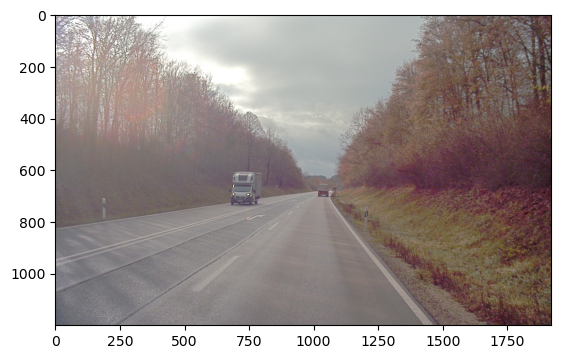

In [ ]:
img_path = '/home/morten/Downloads/20181204_170238/camera/cam_front_center/20181204170238_camera_frontcenter_000000330.png'
# label_path = '/home/morten/Documents/Data/data_lane_segmentation/val_label/Town04_Clear_Noon_09_09_2020_14_57_22_frame_1061_validation_set_label.png'
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR, img)
img = img[8:1208, :, :]
print(img.shape)
# label = cv2.imread(label_path)
plt.imshow(img)
plt.show()

In [ ]:
camera = CameraG()
camera.get_fit_and_probs(img, sld)

back_probs, left_probs, right_probs = sld.detect(img)

print(left_probs.shape)

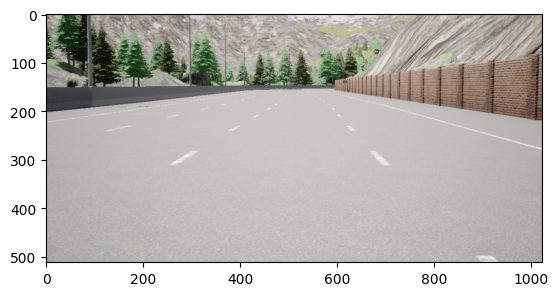

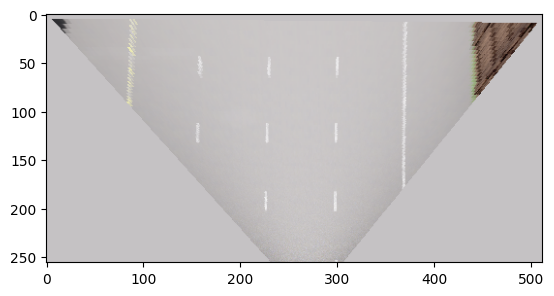

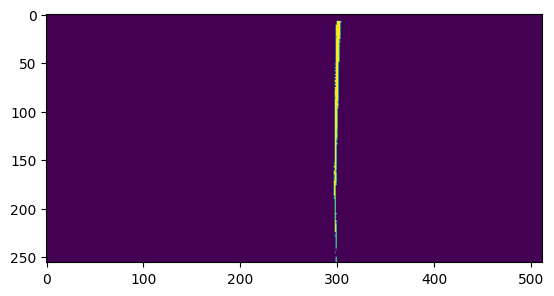

(256, 512)
256


In [ ]:
if __name__ == "__main__":

    camera_info = _DictObjHolder({
        "f_x": camera.intrinsic_matrix[0,0],             # focal length x
        "f_y": camera.intrinsic_matrix[1,1],             # focal length y
        "u_x": camera.intrinsic_matrix[0,2],             # optical center x
        "u_y": camera.intrinsic_matrix[1,2],             # optical center y
        "camera_height": camera.estimated_height*1000,   # camera height in `mm`
        "pitch": 90 - camera.estimated_pitch_deg,        # rotation degree around x
        "yaw": camera.estimated_yaw_deg                  # rotation degree around y
    })
    ipm_info = _DictObjHolder({
        "input_width": 1024,
        "input_height": 512,
        "out_width": 512,
        "out_height": 256,
        "left": 0,
        "right": 1024,
        "top": 200,
        "bottom": 512
    })

    ipm = IPM(camera_info, ipm_info)
    out_img = ipm(img)
    out_left_probs = ipm(left_probs)
    out_right_probs = ipm(right_probs)

    plt.imshow(img)
    plt.show()
    plt.imshow(out_img)
    plt.show()
    plt.imshow(out_right_probs)
    plt.show()


    print(out_left_probs.shape)
    print(len(out_left_probs))

In [ ]:
def ipm_roi(img, sld, camera):
    camera.get_fit_and_probs(img, sld)
    _, left_probs, right_probs = sld.detect(img)
    camera_info = _DictObjHolder({
        "f_x": camera.intrinsic_matrix[0,0],             # focal length x
        "f_y": camera.intrinsic_matrix[1,1],             # focal length y
        "u_x": camera.intrinsic_matrix[0,2],             # optical center x
        "u_y": camera.intrinsic_matrix[1,2],             # optical center y
        "camera_height": camera.estimated_height*1000,   # camera height in `mm`
        "pitch": 90 - camera.estimated_pitch_deg,        # rotation degree around x
        "yaw": camera.estimated_yaw_deg                  # rotation degree around y
    })
    ipm_info = _DictObjHolder({
        "input_width": 1024,
        "input_height": 512,
        "out_width": 1024,
        "out_height": 512,
        "left": 0,
        "right": 1024,
        "top": 200,
        "bottom": 512
    })
    ipm = IPM(camera_info, ipm_info)
    ipm_img = ipm(img)
    ipm_left_probs = ipm(left_probs)
    ipm_right_probs = ipm(right_probs)

    left_u = 0
    right_u = 0

    # Check the last fifty rows of the ipm of the lane probabilities and find where the lane starts
    for i in range(ipm_left_probs.shape[0] - 1, ipm_left_probs.shape[0]-51, -1):
        for j in range(0, ipm_left_probs.shape[1]):
            if ipm_left_probs[i][j] > 0.5:
                left_u = j
                break
    # Check the last fifty rows of the ipm of the lane probabilities and find where the lane starts
    for i in range(ipm_right_probs.shape[0] - 1, ipm_right_probs.shape[0]-51, -1):
        for j in range(0, ipm_right_probs.shape[1]):
            if ipm_right_probs[i][j] > 0.5:
                right_u = j
                break

    # find the middle of the lane, probably not the exact middle but close
    roi_u = right_u - left_u
    middle_u = left_u + roi_u/2

    # from the middle go left and right 100 units, this is subject to change of course
    left_u = middle_u - 100
    right_u = middle_u + 100

    # round down
    left_u = np.floor(left_u).astype(int)
    right_u = np.floor(right_u).astype(int)

    # limit top and bottom of roi
    top_v = 200
    bottom_v = 450

    # Create the roi_output
    roi_output = ipm_img[top_v:bottom_v, left_u:right_u]

    return roi_output

roi = ipm_roi(img, sld, camera)

In [ ]:
cv2.imwrite('try_ipm.png', roi)

True